In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import itertools
from scipy.stats import zscore

%matplotlib inline

# Suppress the PerformanceWarning
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

- Wheat contracts and discontinuities due to contracts. Sanctions due to war. How much comes from where. Red sea/Suez Canal.
- Shipping data and assumptions. Data may or may not include shipping costs, insurance etc.
- Make assumption.
- Time series: Forecasts to 2040 and compare to economic forecasts
- Fit back Q to ann from 2025 to 2020 then fit to 2005 and use.

Tukey method

In [3]:
ann_meat_df = pd.read_csv('cleaned_data/annual_meat.csv') 
ann_meat_df = ann_meat_df[ann_meat_df['Concept'] == 'Total Trade Real Value']
# ann_meat_df = ann_meat_df[~ann_meat_df['ImporterCountry'].isin(['Other Europe, nes.', 'Areas, not elsewhere specified', 'World Total'])]
# ann_meat_df = ann_meat_df[~ann_meat_df['ExporterCountry'].isin(['Other Europe, nes.', 'Areas, not elsewhere specified', 'World Total'])]

ann_wheat_df = pd.read_csv('cleaned_data/annual_wheat.csv')
ann_wheat_df = ann_wheat_df[ann_wheat_df['Concept'] == 'Total Trade Real Value']
# ann_wheat_df = ann_wheat_df[~ann_wheat_df['ImporterCountry'].isin(['Other Europe, nes.', 'Areas, not elsewhere specified', 'World Total'])]
# ann_wheat_df = ann_wheat_df[~ann_wheat_df['ExporterCountry'].isin(['Other Europe, nes.', 'Areas, not elsewhere specified', 'World Total'])]

ann_metals_df = pd.read_csv('cleaned_data/annual_metals.csv')
ann_metals_df = ann_metals_df[ann_metals_df['Concept'] == 'Total Trade Real Value']
# ann_metals_df = ann_metals_df[~ann_metals_df['ImporterCountry'].isin(['Other Europe, nes.', 'Areas, not elsewhere specified', 'World Total'])]
# ann_metals_df = ann_metals_df[~ann_metals_df['ExporterCountry'].isin(['Other Europe, nes.', 'Areas, not elsewhere specified', 'World Total'])]

## Annual Metals Data - Data error detection example

In [4]:
years = [x for x in range(2005, 2035)]
ann_metals_df.columns = ['Concept', 'Import Country/Territory', 'Export Country/Territory', 'Commodity', 'Start Date', 'End Date'] + years

# Creating import and export dataframes
export_df = pd.DataFrame()
import_df = pd.DataFrame()
export_df['Year'] = years
countries = ann_metals_df['Export Country/Territory'].unique()
for country in countries:
    ex_frame = ann_metals_df.loc[(ann_metals_df['Export Country/Territory'] == country)]
    im_frame = ann_metals_df.loc[(ann_metals_df['Import Country/Territory'] == country)]
    ex_values = []
    im_values = []
    for j in years:
        ex_values.append(ex_frame[j].sum(skipna=True))
        im_values.append(im_frame[j].sum(skipna=True))
        
    export_df[country] = ex_values
    import_df[country] = im_values

import_df.index = years
export_df.index = years

# Selecting subset of countries
selected_countries = ['Nicaragua', 'Germany', 'Dominican Republic', 'Singapore', 
                      'Chile', 'Ireland', 'United States', 'Congo, D.R.', 'Zambia', 
                      'Czechia', 'Hungary', 'Sweden', 'Spain', 'Egypt', 'Brazil', 'Iraq', 'Iran', 
                      'Austria', 'Australia', 'Ukraine', 'Honduras', 'Qatar', 'Yemen', 'Vietnam', 'Argentina', 
                      'Japan', 'China (mainland)', 'Venezuela', 'Turkey', 'Taiwan', 'India', 'Philippines', 'Italy', 
                      'South Korea', 'Bulgaria', 'Nepal', 'Ecuador', 'Canada', 'Finland', 'Oman', 'Hong Kong SAR', 'Switzerland', 
                      'Nigeria', 'Peru', 'New Caledonia', 'Netherlands', 'Angola', 'South Africa', 'Lithuania', 
                      'Denmark', 'Estonia', 'Thailand', 'Indonesia', 'Morocco', 'Greece', 'Bangladesh', 'Slovenia', 
                      'United Arab Emirates', 'Iceland', 'Russia', 'Latvia', 'Paraguay', 'Mozambique', 'Costa Rica', 
                      'Romania', 'Afghanistan', 'Saudi Arabia', 'Belgium', 'Croatia', 'Tunisia', 'Uruguay', 'Colombia', 
                      'Bolivia', 'France', 'Norway', 'Mexico', 'Serbia', 'Kazakhstan', 'United Kingdom', 'Slovakia', 'New Zealand',
                      'Algeria', 'Israel', 'Belarus', 'Portugal', 'Congo, Republic of the', 'Malaysia', 'Bahrain', 'Uzbekistan', 'Poland']

import_subset = import_df.loc[:, selected_countries]
export_subset = export_df.loc[:, selected_countries]

temp_exp = export_subset.apply(zscore)
temp_imp = import_subset.apply(zscore)
temp_exp.head(3)

,Nicaragua,Germany,Dominican Republic,Singapore,Chile,Ireland,United States,"Congo, D.R.",Zambia,Czechia,...,New Zealand,Algeria,Israel,Belarus,Portugal,"Congo, Republic of the",Malaysia,Bahrain,Uzbekistan,Poland
2005,-1.329550,-1.317194,-0.258225,-1.242840,0.940356,-0.603958,-1.281587,-1.373868,-2.548857,-1.826284,...,0.552439,-0.676236,-0.797672,-1.009796,-1.192109,-1.557208,-1.446872,-1.767396,-1.588967,-1.815529
2006,-1.057384,-0.514163,-0.178064,-0.790772,1.070413,0.113833,-1.012304,-1.371942,-2.298521,-1.510407,...,0.749127,-0.446477,-0.588164,-0.812398,-0.964662,-1.508096,-1.297040,-1.227719,-1.620029,-1.428107
2007,-0.684871,-0.249281,-0.565800,0.065108,1.783453,0.234061,-0.872924,-1.353719,-2.206059,-1.095035,...,1.902657,-0.137066,-0.426733,-0.847644,-0.640628,-1.376341,-1.181186,-1.286440,-1.345734,-1.221561


### Finding incorrect data in metals data/Linking to events

In [5]:
temp_imp[temp_imp>3].dropna(how='all', axis=1).dropna(how='all', axis=0)
# All three countries cross referenced with other data, confirmed anomalies.

# global economic impact of the COVID-19 pandemic. In 2020, international trade 
# experienced some of the most significant reductions since World War II due to the pandemic,
# with a steep decline in both industrial production and goods trade in the first half of the year. 
# Although there was a recovery in trade in 2021, the overall performance did not completely counterbalance 
# the losses, and trade impacts varied greatly across different goods, services, and trade partners. Services
# trade, for instance, was hit harder than goods trade and has been slower to recover.

,"Congo, Republic of the"
2014,3.348477


In [6]:
temp_imp[temp_imp<-3].dropna(how='all', axis=1).dropna(how='all', axis=0)
# Due to GFC, these are likely to be genuine anomalies

,United Arab Emirates
2005,-3.437579


In [7]:
temp_exp[temp_exp>3].dropna(how='all', axis=1).dropna(how='all', axis=0)
# Afghanistan is an error, the other two are genuine anomalies - validated by other data

,Peru,Mozambique,Afghanistan
2005,3.124879,NaN,NaN
2006,NaN,3.123944,NaN
2009,NaN,NaN,5.093548


<Axes: >

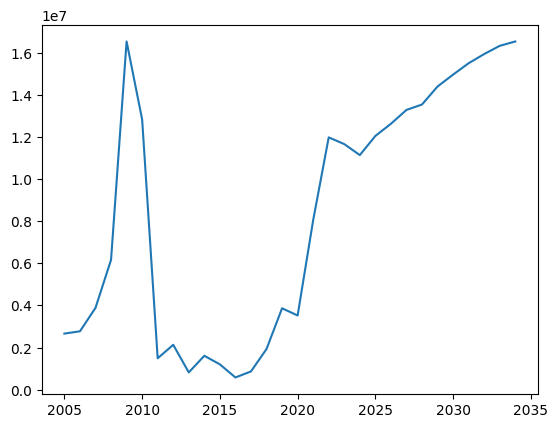

In [8]:
export_df['Afghanistan'] = export_df['Afghanistan'].clip(upper=export_df['Afghanistan'].quantile(0.95))
export_df['Afghanistan'].plot()

- Yemen: Yemen's exports in 2015 were likely affected significantly by the civil war that escalated in March of that year when a coalition led by Saudi Arabia intervened. The conflict caused a severe humanitarian crisis and had devastating effects on the country's economy and infrastructure. Many civilians became victims of the conflict, millions were displaced, and a large portion of the population required urgent aid. The war disrupted normal economic activities, including trade and exports, due to the destruction of civilian infrastructure and agricultural lands, as well as disruptions to food supplies and other essential imports.
Furthermore, the global economic context in 2015 showed a marked slowdown in world exports due to falling commodity prices and volatility in emerging Asian economies. These global trade dynamics, alongside the severe internal challenges faced by Yemen, contributed to the decline in exports from the country.
The situation in Yemen has been described as one of the worst humanitarian crises, with a large percentage of the population requiring assistance due to the combined effects of war, disease, and the threat of famine. The ongoing conflict has significantly undermined the country's ability to engage in international trade, including exports.
- Belarus: Oil collapsed. 2022 sanctions due to war caused massive collapse - In response to Belarus' involvement in Russia's war of aggression against Ukraine, the European Union adopted additional restrictive measures against Belarus starting from March 2022. These included a broadening of the scope of sectoral measures, including sanctions on individuals and entities, restrictions on trade in firearms, dual-use goods, and goods and technology in the aviation, space, and defense industry, as well as a ban on Belarusian road transport operators. The United States and other countries also expanded sanctions on Belarus, targeting state-owned enterprises, government officials, and economic sectors critical to the Belarusian regime.
- All other countries genuine anomalies

In [9]:
temp_exp[temp_exp<-3].dropna(how='all', axis=1).dropna(how='all', axis=0)

""


In [10]:
# Net imports dataframe
# agg_df = import_subset - export_subset

# Z-score dataframe
import_zs = pd.DataFrame(zscore(import_subset.pct_change().iloc[1:,:], axis=0), columns=import_subset.columns, index=years)
import_zs = import_zs.dropna(axis=0, how='all')
export_zs = pd.DataFrame(zscore(export_subset.pct_change().iloc[1:,:], axis=0), columns=export_subset.columns, index=years)
export_zs = export_zs.dropna(axis=0, how='all')
export_zs.head(3)

,Nicaragua,Germany,Dominican Republic,Singapore,Chile,Ireland,United States,"Congo, D.R.",Zambia,Czechia,...,New Zealand,Algeria,Israel,Belarus,Portugal,"Congo, Republic of the",Malaysia,Bahrain,Uzbekistan,Poland
2006,1.682556,1.540365,-0.194378,0.698755,0.533380,1.265294,1.086381,-0.298836,0.801557,0.816196,...,0.203703,0.119779,0.297921,0.690020,0.754203,0.726302,1.186566,3.926618,-0.611264,2.122821
2007,1.175585,0.261518,-0.615769,1.377846,2.127004,-0.005770,0.244444,1.811655,-0.001150,1.062585,...,1.498910,0.113544,0.148796,-0.278525,1.125379,1.504875,0.574828,-0.880410,1.374656,0.645885
2008,0.206203,-0.035586,-0.136886,2.190766,-1.765628,-1.389415,0.597280,3.553591,0.816800,0.868538,...,-0.962595,-0.604757,-0.357290,0.783432,-1.321502,-0.019903,-0.970980,-0.719091,-1.628522,0.754275


Text(0.5, 1.0, 'Anomalies & Z-score for U.S. export % change')

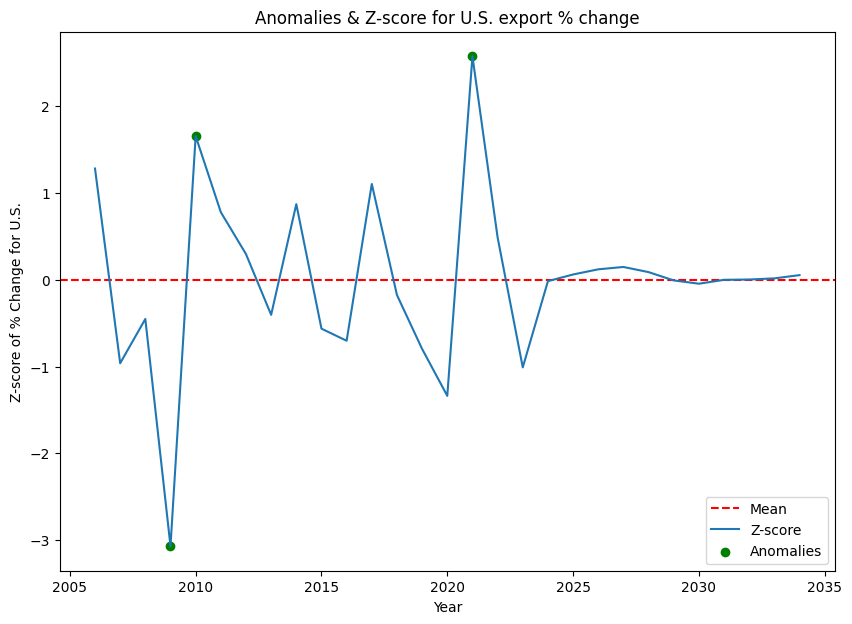

In [11]:
us_zscore = import_zs['United States']

anomaliesID = np.where(np.abs(us_zscore) > 1.5)
anomalies = []
for i in anomaliesID:
    anomalies.append(us_zscore.iloc[i])


fig, ax = plt.subplots(figsize=(10,7))
ax.axhline(y = 0, label = 'Mean', c = 'red', linestyle = '--')
ax.plot(years[1:],us_zscore.values,label = 'Z-score')
ax.scatter([years[i]+1 for i in anomaliesID[0]],anomalies,c = 'green', label = 'Anomalies')
ax.legend(loc='lower right')
ax.set_xlabel('Year')
ax.set_ylabel('Z-score of % Change for U.S.')
ax.set_title('Anomalies & Z-score for U.S. export % change')

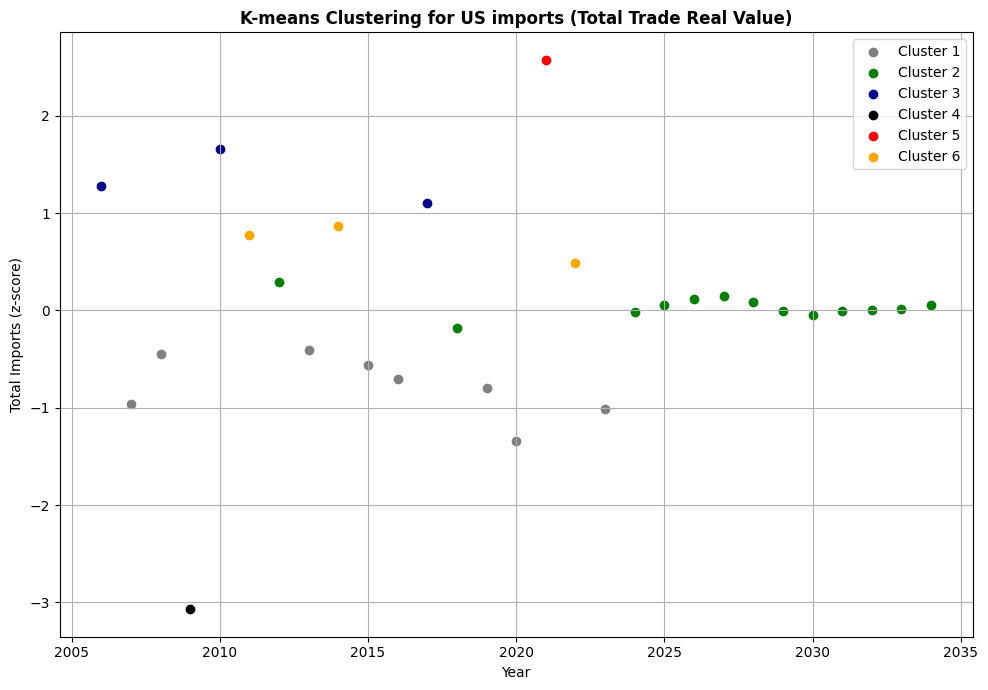

In [12]:
from sklearn.cluster import k_means

import_zs.fillna(0, inplace=True)
kmeans_clusters = {}
for country in import_zs.columns:
    kmeans = k_means(import_zs[country].to_frame(), n_clusters = 6, random_state = 42)
    kmeans_clusters[country] = kmeans[1]

cluster1 = np.where(kmeans_clusters['United States'] == 0, import_zs['United States'], np.nan)
cluster2 = np.where(kmeans_clusters['United States'] == 1, import_zs['United States'], np.nan)
cluster3 = np.where(kmeans_clusters['United States'] == 2, import_zs['United States'], np.nan)
cluster4 = np.where(kmeans_clusters['United States'] == 3, import_zs['United States'], np.nan)
cluster5 = np.where(kmeans_clusters['United States'] == 4, import_zs['United States'], np.nan)
cluster6 = np.where(kmeans_clusters['United States'] == 5, import_zs['United States'], np.nan)

fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(import_zs.index, cluster1, c='grey', label='Cluster 1')
ax.scatter(import_zs.index, cluster2, c='green', label='Cluster 2')
ax.scatter(import_zs.index, cluster3, c='darkblue', label='Cluster 3')
ax.scatter(import_zs.index, cluster4, c='black', label='Cluster 4')
ax.scatter(import_zs.index, cluster5, c='red', label='Cluster 5')
ax.scatter(import_zs.index, cluster6, c='orange', label='Cluster 6')

ax.set_xlabel('Year')
ax.set_ylabel('Total Imports (z-score)')
ax.set_title('K-means Clustering for US imports (Total Trade Real Value)', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.grid()
# plt.savefig('kmeans.png', dpi=600)

### Splitting countries by GDP and detecting anomalies
Splitting countries by size, calculating the empirical PDF (use non-parametric and parametric - Histogram) of anomaly sizes (fat tails CDF, power law and extreme value theory)

In [13]:
# splitting importing countries
lower_imp_cs = []
mid_imp_cs = []
high_imp_cs = []
for country in import_subset.columns:
    if import_subset[country][2011] < import_subset.loc[2011,:].quantile(0.35).mean():
        lower_imp_cs.append(country)
    elif import_subset[country][2011] > import_subset.loc[2011,:].quantile(0.65).mean():
        high_imp_cs.append(country)
    else:
        mid_imp_cs.append(country)
print(len(lower_imp_cs), len(mid_imp_cs), len(high_imp_cs))

32 26 32


In [14]:
# splitting exporting countries
lower_exp_cs = []
mid_exp_cs = []
high_exp_cs = []
for country in export_subset.columns:
    if export_subset[country][2011] < export_subset.loc[2011,:].quantile(0.35).mean():
        lower_exp_cs.append(country)
    elif export_subset[country][2011] > export_subset.loc[2011,:].quantile(0.65).mean():
        high_exp_cs.append(country)
    else:
        mid_exp_cs.append(country)
print(len(lower_exp_cs), len(mid_exp_cs), len(high_exp_cs))

32 26 32


In [15]:
# Getting % change dataframes
low_gdp_exp = export_subset.loc[:,lower_exp_cs].pct_change().iloc[1:,:]
mid_gdp_exp = export_subset.loc[:,mid_exp_cs].pct_change().iloc[1:,:]
high_gdp_exp = export_subset.loc[:,high_exp_cs].pct_change().iloc[1:,:]

low_gdp_imp = import_subset.loc[:,lower_imp_cs].pct_change().iloc[1:,:]
mid_gdp_imp = import_subset.loc[:,mid_imp_cs].pct_change().iloc[1:,:]
high_gdp_imp = import_subset.loc[:,high_imp_cs].pct_change().iloc[1:,:]

In [16]:
# Getting zscore dataframes
low_gdp_exp_z = zscore(low_gdp_exp)
mid_gdp_exp_z = zscore(mid_gdp_exp)
high_gdp_exp_z = zscore(high_gdp_exp)

low_gdp_imp_z = zscore(low_gdp_imp)
mid_gdp_imp_z = zscore(mid_gdp_imp)
high_gdp_imp_z = zscore(high_gdp_imp)

In [17]:
exp_zdfs = [low_gdp_exp_z, mid_gdp_exp_z, high_gdp_exp_z]
exp_pct_dfs = [low_gdp_exp, mid_gdp_exp, high_gdp_exp]
imp_zdfs = [low_gdp_imp_z, mid_gdp_imp_z, high_gdp_imp_z]
imp_pct_dfs = [low_gdp_imp, mid_gdp_imp, high_gdp_imp]

exp_anomalies_low = []
exp_anomalies_mid = []
exp_anomalies_high = []
imp_anomalies_low = []
imp_anomalies_mid = []
imp_anomalies_high = []
for i in range(3):
    exp_indices = (exp_zdfs[i]>3) | (exp_zdfs[i]<-3)
    imp_indices = (imp_zdfs[i]>3) | (imp_zdfs[i]<-3)
    if i == 0:
        temp = np.array(exp_pct_dfs[i][exp_indices].values.flatten())
        exp_anomalies_low.append(temp[~np.isnan(temp)])

        temp = np.array(imp_pct_dfs[i][imp_indices].values.flatten())
        imp_anomalies_low.append(temp[~np.isnan(temp)])
    elif i == 1:
        temp = np.array(exp_pct_dfs[i][exp_indices].values.flatten())
        exp_anomalies_mid.append(temp[~np.isnan(temp)])

        temp = np.array(imp_pct_dfs[i][imp_indices].values.flatten())
        imp_anomalies_mid.append(temp[~np.isnan(temp)])
    else:
        temp = np.array(exp_pct_dfs[i][exp_indices].values.flatten())
        exp_anomalies_high.append(temp[~np.isnan(temp)])

        temp = np.array(imp_pct_dfs[i][imp_indices].values.flatten())
        imp_anomalies_high.append(temp[~np.isnan(temp)])

exp_anomalies = [[], [], []]
imp_anomalies = [[], [], []]

for i in range(3):
    exp_indices = (exp_zdfs[i] > 3) | (exp_zdfs[i] < -3)
    imp_indices = (imp_zdfs[i] > 3) | (imp_zdfs[i] < -3)
    
    temp_exp = np.array(exp_pct_dfs[i][exp_indices].values.flatten())
    temp_imp = np.array(imp_pct_dfs[i][imp_indices].values.flatten())
    
    exp_anomalies[i].extend(temp_exp[~np.isnan(temp_exp)])
    imp_anomalies[i].extend(temp_imp[~np.isnan(temp_imp)])

Text(0.5, 1.0, 'Export % Change Anomalies - Empirical PDF')

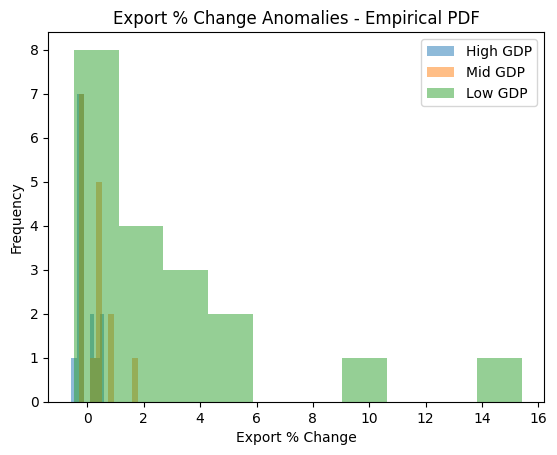

In [18]:
plt.hist(exp_anomalies_high, alpha=0.5, label='High GDP')
plt.hist(exp_anomalies_mid, alpha=0.5, label='Mid GDP')
plt.hist(exp_anomalies_low, alpha=0.5, label='Low GDP')
plt.legend()
plt.xlabel('Export % Change')
plt.ylabel('Frequency')
plt.title('Export % Change Anomalies - Empirical PDF')

Exponential distribution for low GDP countries (large tail), becomes more standard normal for high GDP countries (less anomalies and due to size the % change is not as large)

In [19]:
# exp_anomalies_low,exp_anomalies_mid,exp_anomalies_high,imp_anomalies_low,imp_anomalies_mid,imp_anomalies_high

In [20]:
# join the 3 export arrays and import arrays
exp_temp = np.concatenate((exp_anomalies_low[0],exp_anomalies_mid[0],exp_anomalies_high[0]))
imp_temp = np.concatenate((imp_anomalies_low[0],imp_anomalies_mid[0],imp_anomalies_high[0]))

**concatenate all commodities on exports and imports and see if extreme value theory holds**

Text(0.5, 1.0, 'Export & Import % Change Anomalies - Empirical PDF')

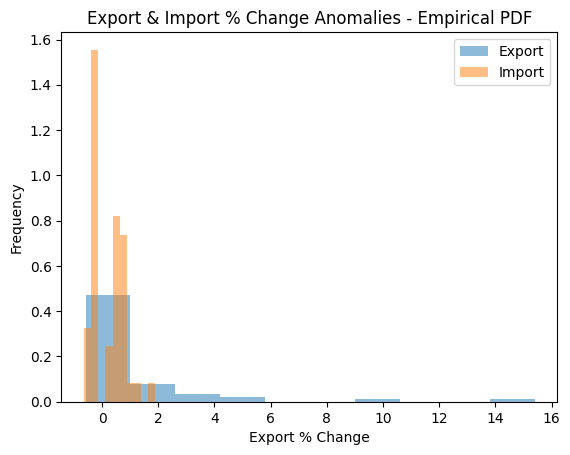

In [21]:
# Empirical PDF from Histogram
plt.hist(exp_temp, alpha=0.5, label='Export', density=True) 
plt.hist(imp_temp, alpha=0.5, label='Import', density=True)
plt.legend()
plt.xlabel('Export % Change')
plt.ylabel('Frequency')
plt.title('Export & Import % Change Anomalies - Empirical PDF')

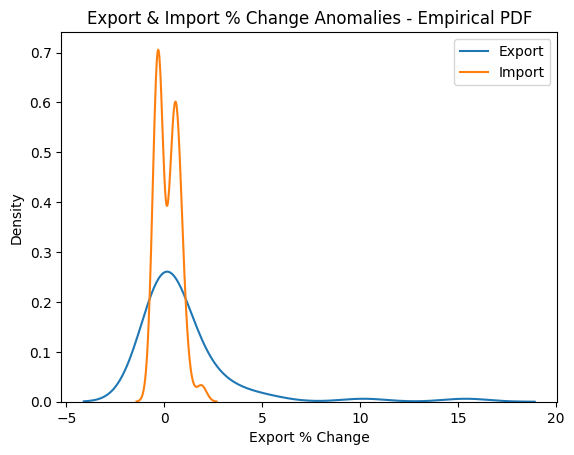

In [22]:
# Non-parametric PDF - 
sns.kdeplot(exp_temp, label='Export')
sns.kdeplot(imp_temp, label='Import')
plt.xlabel('Export % Change')
plt.ylabel('Density')
plt.title('Export & Import % Change Anomalies - Empirical PDF')
plt.legend()

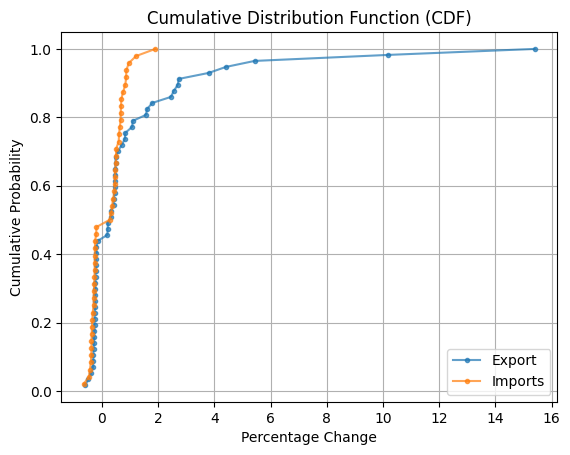

In [23]:
# Compute the CDF
exp_sorted = np.sort(exp_temp)
exp_cumulative_prob = np.arange(1, len(exp_sorted) + 1) / len(exp_sorted)

imp_sorted = np.sort(imp_temp)
imp_cumulative_prob = np.arange(1, len(imp_sorted) + 1) / len(imp_sorted)

# Plot the CDF
plt.plot(exp_sorted, exp_cumulative_prob, marker='.', alpha=0.7, label='Export')
plt.plot(imp_sorted, imp_cumulative_prob, marker='.', alpha=0.7, label='Imports')
plt.xlabel('Percentage Change')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function (CDF)')
plt.grid(True)
plt.legend()
plt.show()

In [24]:
from scipy.stats import kstest, anderson, spearmanr

# Kolmogorov-Smirnov Test
ks_statistic, ks_pvalue = kstest(exp_temp, 'norm')
print(f'Export KS Statistic: {ks_statistic}, P-value: {ks_pvalue}')

ks_statistic, ks_pvalue = kstest(imp_temp, 'norm')
print(f'Import KS Statistic: {ks_statistic}, P-value: {ks_pvalue}')

# Anderson-Darling Test
ad_statistic, ad_critical_values, ad_significance_levels = anderson(exp_temp, dist='norm')
print(f'Export AD Statistic: {ad_statistic}, Critical Values: {ad_critical_values}, Significance Levels: {ad_significance_levels}')

ad_statistic, ad_critical_values, ad_significance_levels = anderson(imp_temp, dist='norm')
print(f'Import AD Statistic: {ad_statistic}, Critical Values: {ad_critical_values}, Significance Levels: {ad_significance_levels}')


Export KS Statistic: 0.3229036217089105, P-value: 8.65077206174714e-06
Import KS Statistic: 0.3002481410456688, P-value: 0.0002468867833817096
Export AD Statistic: 8.393347171988552, Critical Values: [0.542 0.617 0.741 0.864 1.028], Significance Levels: [15.  10.   5.   2.5  1. ]
Import AD Statistic: 2.1737339466711276, Critical Values: [0.537 0.612 0.734 0.856 1.018], Significance Levels: [15.  10.   5.   2.5  1. ]


Text(0, 0.5, 'CCDF')

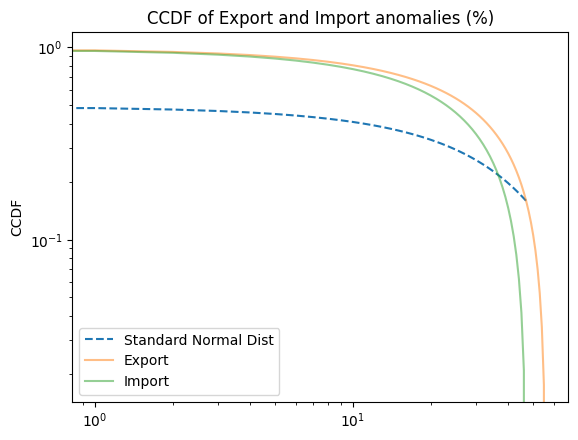

In [25]:
# Fat tails
exp_ccdf = 1 - exp_cumulative_prob
imp_ccdf = 1 - imp_cumulative_prob
normal_ccdf = scipy.stats.norm.sf(imp_cumulative_prob, 0, 1)

plt.loglog(normal_ccdf, alpha=1, label='Standard Normal Dist', linestyle='--')
plt.loglog(exp_ccdf, alpha=0.5, label='Export')
plt.loglog(imp_ccdf, alpha=0.5, label='Import')
plt.legend()
plt.title('CCDF of Export and Import anomalies (%)')
plt.ylabel('CCDF')

Because anomalies are normally due to shocks (wars, sanctions etc) its very hard to predict ahead of time without alt data (senitment, news data etc)

Analysing this data, it seems over 4.5std moves are anomalies, unfortunately there is not other way to find errors vs anomalies, so all 4.5std moves will be clipped to the 95%tile of the data.

### Finding relationships in the anomalies 
- Covariance/correlation between anomalies across clusters

In [26]:
exp_zdfs = [low_gdp_exp_z, mid_gdp_exp_z, high_gdp_exp_z]
exp_pct_dfs = [low_gdp_exp, mid_gdp_exp, high_gdp_exp]
imp_zdfs = [low_gdp_imp_z, mid_gdp_imp_z, high_gdp_imp_z]
imp_pct_dfs = [low_gdp_imp, mid_gdp_imp, high_gdp_imp]

exp_anomalies_low = []
exp_anomalies_mid = []
exp_anomalies_high = []
imp_anomalies_low = []
imp_anomalies_mid = []
imp_anomalies_high = []

# Define function to find anomalies and store their index and column name
def find_anomalies_indices(z_scores_df, anomalies_list):
    indices = (z_scores_df > 3) | (z_scores_df < -3)
    for column in z_scores_df.columns:
        for index, value in indices[column].items():
            if value:
                anomalies_list.append((index, column))

# Find anomalies for each z-score dataframe
exp_anomalies = [exp_anomalies_low, exp_anomalies_mid, exp_anomalies_high]
imp_anomalies = [imp_anomalies_low, imp_anomalies_mid, imp_anomalies_high]
for i in range(3):
    find_anomalies_indices(exp_zdfs[i], exp_anomalies[i])
    find_anomalies_indices(imp_zdfs[i], imp_anomalies[i])

As country size grows, anomalies become more correlated. Almost all large country anomalies came during covid/GFC, where small countries were more sparse and independent of year

- Can we find predictive power in these anomalies, does it always revert?

In [27]:
# pct_change in year after upward or downward shock - should be mean reverting
exp_zdfs = [low_gdp_exp_z, mid_gdp_exp_z, high_gdp_exp_z]
exp_pct_dfs = [low_gdp_exp, mid_gdp_exp, high_gdp_exp]
imp_zdfs = [low_gdp_imp_z, mid_gdp_imp_z, high_gdp_imp_z]
imp_pct_dfs = [low_gdp_imp, mid_gdp_imp, high_gdp_imp]

exp_anomalies_low_up = []
exp_anomalies_mid_up = []
exp_anomalies_high_up = []
exp_anomalies_low_down = []
exp_anomalies_mid_down = []
exp_anomalies_high_down = []

imp_anomalies_low_up = []
imp_anomalies_mid_up = []
imp_anomalies_high_up = []
imp_anomalies_low_down = []
imp_anomalies_mid_down = []
imp_anomalies_high_down = []

# Define function to find anomalies and store the indices of the next value
def find_anomalies_next_indices(z_scores_df, pct_df, anomalies_up_list, anomalies_down_list):
    indices_up = z_scores_df > 3
    indices_down = z_scores_df < -3
    for column in z_scores_df.columns:
        for index, value in indices_up[column].items():
            if value:
                # Append index of the next value after the anomaly
                next_index = index + 1
                if next_index < pct_df.index[-1]:
                    anomalies_up_list.append(pct_df.loc[next_index, column])
        for index, value in indices_down[column].items():
            if value:
                # Append index of the next value after the anomaly
                next_index = index + 1
                if next_index < pct_df.index[-1]:
                    anomalies_down_list.append(pct_df.loc[next_index, column])

# Find anomalies for each z-score dataframe
exp_ups = [exp_anomalies_low_up, exp_anomalies_mid_up, exp_anomalies_high_up]
exp_downs = [exp_anomalies_low_down, exp_anomalies_mid_down, exp_anomalies_high_down]
imp_ups = [imp_anomalies_low_up, imp_anomalies_mid_up, imp_anomalies_high_up]
imp_downs = [imp_anomalies_low_down, imp_anomalies_mid_down, imp_anomalies_high_down]
for i in range(3):
    find_anomalies_next_indices(exp_zdfs[i], exp_pct_dfs[i], exp_ups[i], exp_downs[i])
    find_anomalies_next_indices(imp_zdfs[i], imp_pct_dfs[i], imp_ups[i], imp_downs[i])

In [28]:
# count number of positive vs negative values for each of the 4 lists- exp_ups, exp_downs, imp_ups, imp_downs
exp_ups_pos = len([x for x in exp_ups[0] if x > 0]) + len([x for x in exp_ups[1] if x > 0]) + len([x for x in exp_ups[2] if x > 0])
exp_ups_neg = len([x for x in exp_ups[0] if x < 0]) + len([x for x in exp_ups[1] if x < 0]) + len([x for x in exp_ups[2] if x < 0])
exp_downs_pos = len([x for x in exp_downs[0] if x > 0]) + len([x for x in exp_downs[1] if x > 0]) + len([x for x in exp_downs[2] if x > 0])
exp_downs_neg = len([x for x in exp_downs[0] if x < 0]) + len([x for x in exp_downs[1] if x < 0]) + len([x for x in exp_downs[2] if x < 0])
print(exp_ups_pos, exp_ups_neg, exp_downs_pos, exp_downs_neg)

imp_ups_pos = len([x for x in imp_ups[0] if x > 0]) + len([x for x in imp_ups[1] if x > 0]) + len([x for x in imp_ups[2] if x > 0])
imp_ups_neg = len([x for x in imp_ups[0] if x < 0]) + len([x for x in imp_ups[1] if x < 0]) + len([x for x in imp_ups[2] if x < 0])
imp_downs_pos = len([x for x in imp_downs[0] if x > 0]) + len([x for x in imp_downs[1] if x > 0]) + len([x for x in imp_downs[2] if x > 0])
imp_downs_neg = len([x for x in imp_downs[0] if x < 0]) + len([x for x in imp_downs[1] if x < 0]) + len([x for x in imp_downs[2] if x < 0])
print(imp_ups_pos, imp_ups_neg, imp_downs_pos, imp_downs_neg)

17 15 24 1
9 16 21 2


Downs always mean-revert and ups are 50/50. This supports financial evidence that commodities mean revert, but the skew is interesting. This may be because downward shocks are often due to short-term things, where upward shocks are due to long-term trends (EVs = upward revision in metals demand for a long time etc)

https://github.com/SHABARIGIRI/Anomaly-Detection/blob/main/Anomaly_Detection_PyOD.ipynb

# **Applying to all Annual data**

In [29]:
def process_data(df, commodity, subset_countries=None):
    
    if commodity == 'metals':
        years = list(range(2005, 2035))
    else:
        years = list(range(2005, 2041))

    df.columns = ['Concept', 'Import Country/Territory', 
                  'Export Country/Territory', 'Commodity',
                  'Start Date', 'End Date'] + years

    export_df, import_df = pd.DataFrame(), pd.DataFrame()
    export_df['Year'] = years
    countries = df['Export Country/Territory'].unique()
    for i, country in enumerate(countries):
        ex_frame = df.loc[(df['Export Country/Territory'] == country)]
        im_frame = df.loc[(df['Import Country/Territory'] == country)]
        ex_values = []
        im_values = []
        for j in years:
            ex_values.append(ex_frame[j].sum(skipna=True))
            im_values.append(im_frame[j].sum(skipna=True))
            
        export_df[country] = ex_values
        import_df[country] = im_values
    # export_df = pd.DataFrame(index=years, columns=df['Export Country/Territory'].unique(), 
    #                          data=df['Export Country/Territory'].sum(skipna=True))
    # import_df = pd.DataFrame(index=years, columns=df['Import Country/Territory'].unique(), 
    #                          data=df['Import Country/Territory'].sum(skipna=True))


    import_df.index = years
    export_df.index = years

    if subset_countries:
        import_df = import_df.loc[:, subset_countries]
        export_df = export_df.loc[:, subset_countries]
    
    export_zs = zscore(export_df.pct_change().iloc[1:,:], axis=0)
    export_zs = export_zs.dropna(axis=0, how='all')
    import_zs = zscore(import_df.pct_change().iloc[1:,:], axis=0)
    import_zs = import_zs.dropna(axis=0, how='all')

    return export_df, import_df, export_zs, import_zs

In [30]:
ann_dfs = [ann_meat_df, ann_wheat_df, ann_metals_df]
ann_dict = {}

for i, df in enumerate(ann_dfs):
    if i == 0:
        commodity = 'meat'
        temp_countries = selected_countries.copy()
        temp_countries.remove('Yemen')
        temp_countries.remove('Nepal')
        temp_countries.remove('Mozambique')
    elif i == 1:
        commodity = 'wheat'
        temp_countries = selected_countries
    else:
        commodity = 'metals'
        temp_countries = selected_countries
    
    export_df, import_df, export_zs, import_zs = process_data(df, commodity, subset_countries=temp_countries) 
    for df in [export_df, import_df, export_zs, import_zs]:
        if 'World Total' in df.columns:
            df.drop(columns=['World Total'], inplace=True, axis=1)
        if 'Other Europe, nes.' in df.columns:
            df.drop(columns=['Other Europe, nes.'], inplace=True, axis=1)
        if 'Areas, not elsewhere specified' in df.columns:
            df.drop(columns=['Areas, not elsewhere specified'], inplace=True, axis=1)
    ann_dict[commodity] = {'export_df': export_df,
                           'import_df': import_df,
                           'export_zs': export_zs,
                           'import_zs': import_zs}

In [31]:
gdp_split = {'meat':{}, 'wheat':{}, 'metals':{}}
for key in ann_dict:
    export_df = ann_dict[key]['export_df']
    import_df = ann_dict[key]['import_df']
    
    lower_imp_cs = []
    mid_imp_cs = []
    high_imp_cs = []
    for country in import_df.columns:
        if import_df[country][2015] < import_df.loc[2015,:].quantile(0.35).mean():
            lower_imp_cs.append(country)
        elif import_df[country][2015] > import_df.loc[2015,:].quantile(0.65).mean():
            high_imp_cs.append(country)
        else:
            mid_imp_cs.append(country)

    lower_exp_cs = []
    mid_exp_cs = []
    high_exp_cs = []
    for country in export_df.columns:
        if export_df[country][2015] < export_df.loc[2015,:].quantile(0.35).mean():
            lower_exp_cs.append(country)
        elif export_df[country][2015] > export_df.loc[2015,:].quantile(0.65).mean():
            high_exp_cs.append(country)
        else:
            mid_exp_cs.append(country)
    
    low_gdp_exp = export_df.loc[:,lower_exp_cs].pct_change().iloc[1:,:]
    mid_gdp_exp = export_df.loc[:,mid_exp_cs].pct_change().iloc[1:,:]
    high_gdp_exp = export_df.loc[:,high_exp_cs].pct_change().iloc[1:,:]

    low_gdp_imp = import_df.loc[:,lower_imp_cs].pct_change().iloc[1:,:]
    mid_gdp_imp = import_df.loc[:,mid_imp_cs].pct_change().iloc[1:,:]
    high_gdp_imp = import_df.loc[:,high_imp_cs].pct_change().iloc[1:,:]

    low_gdp_exp_z = zscore(low_gdp_exp)
    mid_gdp_exp_z = zscore(mid_gdp_exp)
    high_gdp_exp_z = zscore(high_gdp_exp)

    low_gdp_imp_z = zscore(low_gdp_imp)
    mid_gdp_imp_z = zscore(mid_gdp_imp)
    high_gdp_imp_z = zscore(high_gdp_imp)

    gdp_split[key]['low_gdp_exp'] = low_gdp_exp
    gdp_split[key]['mid_gdp_exp'] = mid_gdp_exp
    gdp_split[key]['high_gdp_exp'] = high_gdp_exp
    gdp_split[key]['low_gdp_imp'] = low_gdp_imp
    gdp_split[key]['mid_gdp_imp'] = mid_gdp_imp
    gdp_split[key]['high_gdp_imp'] = high_gdp_imp    
    
    gdp_split[key]['low_gdp_exp_z'] = low_gdp_exp_z
    gdp_split[key]['mid_gdp_exp_z'] = mid_gdp_exp_z
    gdp_split[key]['high_gdp_exp_z'] = high_gdp_exp_z
    gdp_split[key]['low_gdp_imp_z'] = low_gdp_imp_z
    gdp_split[key]['mid_gdp_imp_z'] = mid_gdp_imp_z
    gdp_split[key]['high_gdp_imp_z'] = high_gdp_imp_z

In [32]:
gdp_anomalies = {'meat': {}, 'wheat': {}, 'metals': {}}
for key in gdp_split:
    exp_zdfs = [gdp_split[key]['low_gdp_exp_z'], gdp_split[key]['mid_gdp_exp_z'], gdp_split[key]['high_gdp_exp_z']]
    exp_pct_dfs = [gdp_split[key]['low_gdp_exp'], gdp_split[key]['mid_gdp_exp'], gdp_split[key]['high_gdp_exp']]
    imp_zdfs = [gdp_split[key]['low_gdp_imp_z'], gdp_split[key]['mid_gdp_imp_z'], gdp_split[key]['high_gdp_imp_z']]
    imp_pct_dfs = [gdp_split[key]['low_gdp_imp'], gdp_split[key]['mid_gdp_imp'], gdp_split[key]['high_gdp_imp']]

    exp_anomalies = [[], [], []]
    imp_anomalies = [[], [], []]

    for i in range(3): # FIND ANOMALIES FUNCTION ABOVE
        exp_indices = (exp_zdfs[i] > 3) | (exp_zdfs[i] < -3)
        imp_indices = (imp_zdfs[i] > 3) | (imp_zdfs[i] < -3)
        
        temp_exp = np.array(exp_pct_dfs[i][exp_indices].values.flatten())
        temp_imp = np.array(imp_pct_dfs[i][imp_indices].values.flatten())
        
        exp_anomalies[i].extend(temp_exp[~np.isnan(temp_exp)])
        imp_anomalies[i].extend(temp_imp[~np.isnan(temp_imp)])
    
    gdp_anomalies[key]['exp_anomalies'] = exp_anomalies
    gdp_anomalies[key]['imp_anomalies'] = imp_anomalies

### Extreme Value Theory - all anomalies
Concatenate all postive (and negative) anomalies across commodities and test distribution for Generalised Pareto Distribution. Analysing the tails seperately since they may be have differently

In [33]:
positive_values = []
negative_values = []
for key in gdp_anomalies:
    for i in range(3):
        etemp = np.array(gdp_anomalies[key]['exp_anomalies'][i])
        itemp = np.array(gdp_anomalies[key]['imp_anomalies'][i])
        

        positive_values.extend([x for x in etemp if x > 0])
        positive_values.extend([x for x in itemp if x > 0])
        negative_values.extend([x for x in etemp if x < 0])
        negative_values.extend([x for x in itemp if x < 0])

Text(0.5, 1.0, 'Import and Export % Change Anomalies - Empirical PDF')

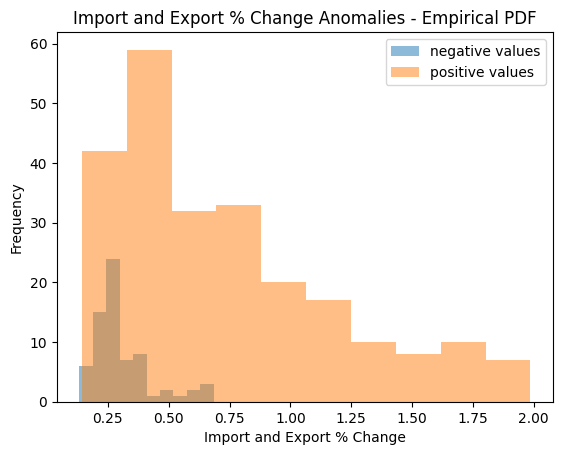

In [34]:
# plt.hist(positive_values, alpha=0.5, label='positive values')
plt.hist(np.abs(negative_values), alpha=0.5, label='negative values')
temppy = np.array(positive_values)[np.array(positive_values)<2]
plt.hist(temppy, alpha=0.5, label='positive values')
plt.legend()
plt.xlabel('Import and Export % Change')
plt.ylabel('Frequency')
plt.title('Import and Export % Change Anomalies - Empirical PDF')

### KDE Plot

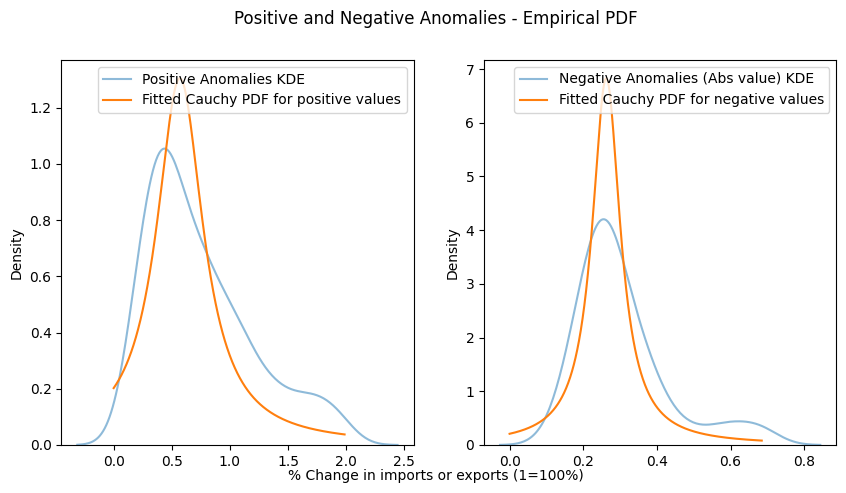

In [35]:
from scipy.stats import cauchy, genpareto

fig, ax = plt.subplots(1,2, figsize=(10,5))
# Plot for positive values
sns.kdeplot(temppy, alpha=0.5, label='Positive Anomalies KDE', ax=ax[0])
loc, scale = cauchy.fit(temppy)
x_values = np.linspace(0, max(temppy), 1000)
fitted_pdf = cauchy.pdf(x_values, loc=loc, scale=scale)
ax[0].plot(x_values, fitted_pdf, label='Fitted Cauchy PDF for positive values')

# Plot for negative values
sns.kdeplot(np.abs(negative_values), alpha=0.5, label='Negative Anomalies (Abs value) KDE', ax=ax[1])
loc, scale = cauchy.fit(np.abs(negative_values))
x_values = np.linspace(0, max(np.abs(negative_values)), 1000)
fitted_pdf = cauchy.pdf(x_values, loc=loc, scale=scale)
ax[1].plot(x_values, fitted_pdf, label='Fitted Cauchy PDF for negative values')

# Adjust legend
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

# Set common labels and title
fig.text(0.5, 0.04, '% Change in imports or exports (1=100%)', ha='center')
# fig.text(0.04, 0.5, va='center', rotation='vertical')
fig.suptitle('Positive and Negative Anomalies - Empirical PDF')

plt.savefig('cauchy_empir_allanoms.png', dpi=600)
plt.show()

### Tests
KL Divergence:

In [36]:
from scipy.stats import norm, cauchy, entropy, gaussian_kde

# Positive anomalies
cauchy_loc, cauchy_scale = cauchy.fit(temppy)

x_values = np.linspace(0, max(temppy), 1000)
cauchy_pdf = cauchy.pdf(x_values, loc=cauchy_loc, scale=cauchy_scale)

# Compute empirical PDF of your data
empirical_pdf_values = gaussian_kde(temppy)(x_values)

# Compute KL divergences
kl_cauchy = entropy(empirical_pdf_values, cauchy_pdf)
print("KL Divergence (Cauchy):", kl_cauchy)

KL Divergence (Cauchy): 0.08512885119169109


In [37]:
from scipy.stats import chi2

# Degrees of freedom (determined by the number of bins)
# You may need to adjust the number of bins depending on your data
degrees_of_freedom = len(x_values) - 1

# Choose significance level
alpha = 0.5

# Compute critical value from the chi-square distribution
critical_value = chi2.ppf(1 - alpha, degrees_of_freedom)

# Make a decision based on KL divergence values
if kl_cauchy > critical_value:
    print("Reject null hypothesis: Empirical distribution significantly different from Cauchy distribution.")
else:
    print("Fail to reject null hypothesis: No significant difference between empirical and Cauchy distributions.")

Fail to reject null hypothesis: No significant difference between empirical and Cauchy distributions.


In [38]:
from scipy.stats import norm, cauchy, entropy, gaussian_kde

# Negative anomalies
cauchy_loc, cauchy_scale = cauchy.fit(np.abs(negative_values))

x_values = np.linspace(0, max(np.abs(negative_values)), 1000)
cauchy_pdf = cauchy.pdf(x_values, loc=cauchy_loc, scale=cauchy_scale)

# Compute empirical PDF of your data
empirical_pdf_values = gaussian_kde(np.abs(negative_values))(x_values)

# Compute KL divergences
kl_cauchy = entropy(empirical_pdf_values, cauchy_pdf)

print("KL Divergence (Cauchy):", kl_cauchy)

KL Divergence (Cauchy): 0.11061976471927969


In [39]:
degrees_of_freedom = len(x_values) - 1

# Compute critical value from the chi-square distribution
critical_value = chi2.ppf(1 - alpha, degrees_of_freedom)

# Make a decision based on KL divergence values
if kl_cauchy > critical_value:
    print("Reject null hypothesis: Empirical distribution significantly different from Cauchy distribution.")
else:
    print("Fail to reject null hypothesis: No significant difference between empirical and Cauchy distributions.")

Fail to reject null hypothesis: No significant difference between empirical and Cauchy distributions.


KS, cramer von mises and Anderson-Darling Tests

In [40]:
from scipy.stats import kstest, cramervonmises, anderson

# POSITIVE ANOMALIES
loc, scale = cauchy.fit(temppy)
ks_statistic, ks_p_value = kstest(temppy, 'cauchy', args=(loc, scale))
cv_stat = cramervonmises(temppy, 'cauchy', args=(loc, scale))
and_test = anderson(temppy, dist='norm')

alpha = 0.01
print('Positive Values:')
print('KS Test:')
if ks_p_value < alpha:
    print("Reject null hypothesis: Data does not follow a Cauchy distribution.")
else:
    print("Fail to reject null hypothesis: Data may follow a Cauchy distribution.")
print('\nCV Test:')
if cv_stat.pvalue < alpha:
    print("Reject null hypothesis: Data does not follow a Cauchy distribution.")
else:
    print("Fail to reject null hypothesis: Data may follow a Cauchy distribution.")

print('\nAnderson Darling test:')
print('Statistic: %.3f' % and_test.statistic)
significance_levels = and_test.significance_level
critical_values = and_test.critical_values
for sl, cv in zip(significance_levels, critical_values):
    if sl in (1, 5):  # Check only for 1% and 5% levels
        if and_test.statistic < cv:
            print('%.1f%%: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.1f%%: %.3f, data does not look normal (reject H0)' % (sl, cv))


# NEGATIVE ANOMALIES
loc, scale = cauchy.fit(np.abs(negative_values))
ks_statistic, ks_p_value = kstest(np.abs(negative_values), 'cauchy', args=(loc, scale))
cv_stat = cramervonmises(np.abs(negative_values), 'cauchy', args=(loc, scale))
print('_______')
print('\nNegative Values:')
print('KS Test:')
if ks_p_value < alpha:
    print("Reject null hypothesis: Data does not follow a Cauchy distribution.")
else:
    print("Fail to reject null hypothesis: Data may follow a Cauchy distribution.")
print('CV Test:')
if cv_stat.pvalue < alpha:
    print("Reject null hypothesis: Data does not follow a Cauchy distribution.")
else:
    print("Fail to reject null hypothesis: Data may follow a Cauchy distribution.")

print('\nAnderson Darling test:')
and_test = anderson(np.abs(negative_values), dist='norm')
print('Statistic: %.3f' % and_test.statistic)
significance_levels = and_test.significance_level
critical_values = and_test.critical_values
for sl, cv in zip(significance_levels, critical_values):
    if sl in (1, 5):  # Check only for 1% and 5% levels
        if and_test.statistic < cv:
            print('%.1f%%: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.1f%%: %.3f, data does not look normal (reject H0)' % (sl, cv))

Positive Values:
KS Test:
Reject null hypothesis: Data does not follow a Cauchy distribution.

CV Test:
Reject null hypothesis: Data does not follow a Cauchy distribution.

Anderson Darling test:
Statistic: 6.717
5.0%: 0.774, data does not look normal (reject H0)
1.0%: 1.074, data does not look normal (reject H0)
_______

Negative Values:
KS Test:
Fail to reject null hypothesis: Data may follow a Cauchy distribution.
CV Test:
Fail to reject null hypothesis: Data may follow a Cauchy distribution.

Anderson Darling test:
Statistic: 3.486
5.0%: 0.748, data does not look normal (reject H0)
1.0%: 1.037, data does not look normal (reject H0)


## Empirical PDFs

In [41]:
dfs = [gdp_anomalies['meat']['exp_anomalies'], gdp_anomalies['wheat']['exp_anomalies']]
for dict in dfs:
    for df in dict:
        # drop all values > 2
        df = np.array(df)
        df = df[df < 2]

In [42]:
commodity='metals'
anomaly_type='imp_anomalies'
# plt.hist(gdp_anomalies[commodity][anomaly_type][2], alpha=0.5, label='High GDP')
# plt.hist(gdp_anomalies[commodity][anomaly_type][1], alpha=0.5, label='Mid GDP')
# plt.hist(gdp_anomalies[commodity][anomaly_type][0], alpha=0.5, label='Low GDP')
# plt.legend()
# plt.xlabel('Im/Ex port % Change')
# plt.ylabel('Frequency')
# plt.title('Im/Ex port % Change Anomalies - Empirical PDF')

In [43]:
exp_temp = np.concatenate((gdp_anomalies[commodity]['exp_anomalies'][2],
                           gdp_anomalies[commodity]['exp_anomalies'][1],
                           gdp_anomalies[commodity]['exp_anomalies'][0]))
exp_sorted = np.sort(exp_temp)[:-5] # wheat and meat have 1 huge value thats likely an error
imp_temp = np.concatenate((gdp_anomalies[commodity]['imp_anomalies'][2],
                           gdp_anomalies[commodity]['imp_anomalies'][1],
                           gdp_anomalies[commodity]['imp_anomalies'][0]))
print(np.mean(exp_sorted), np.mean(imp_temp))
print(np.std(exp_sorted), np.std(imp_temp))
# skew and kurtosis
print(scipy.stats.skew(exp_sorted), scipy.stats.skew(imp_temp))
print(scipy.stats.kurtosis(exp_sorted), scipy.stats.kurtosis(imp_temp))

0.3632345725498706 0.18751359621521804
0.8495993436878683 0.5540746717758446
1.447629903225728 0.6060891668251597
1.332339450432256 -0.09280886080705075


Metals exports imports
mu 1.0194272168501513 0.18751359621521804
std 2.6134657914562585 0.5540746717758446
sk 3.7808913598831464 0.6060891668251597
kurt 15.99069450364546 -0.09280886080705075

Meat exports imports
1.0670906357827392 0.8437255091534088
1.040608434100186 1.1078358487076725
1.1840889227576314 2.0665898623852037
0.4832849079187045 5.316854097641244

Wheat exports imports
2.0909946800536323 1.325612062841432
2.791925254789341 2.3909086063095537
2.4634000517756753 3.970567123469666
5.900408660011882 17.460314250192344

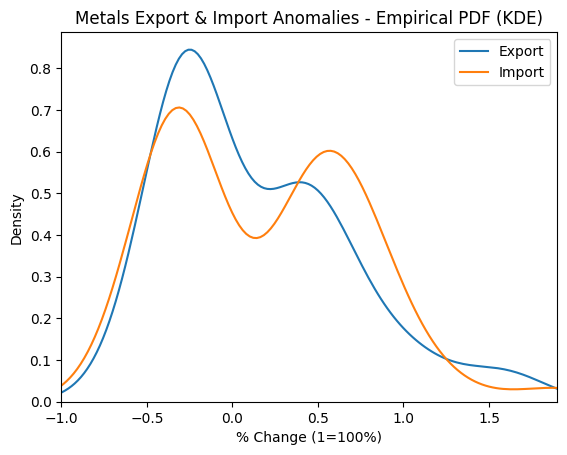

In [44]:
# join the 3 export arrays and import arrays
exp_temp = np.concatenate((gdp_anomalies[commodity]['exp_anomalies'][2],
                           gdp_anomalies[commodity]['exp_anomalies'][1],
                           gdp_anomalies[commodity]['exp_anomalies'][0]))
exp_sorted = np.sort(exp_temp)
exp_sorted = exp_sorted[:-10] # wheat and meat have 1 huge value thats likely an error
imp_temp = np.concatenate((gdp_anomalies[commodity]['imp_anomalies'][2],
                           gdp_anomalies[commodity]['imp_anomalies'][1],
                           gdp_anomalies[commodity]['imp_anomalies'][0]))
imp_sorted = np.sort(imp_temp)

# Non-parametric PDF - 
sns.kdeplot(exp_sorted, label='Export')
sns.kdeplot(imp_sorted, label='Import')
plt.xlabel('% Change (1=100%)')
plt.xlim(-1,max(max(exp_sorted),max(imp_sorted)))
plt.ylabel('Density')
plt.title('Metals Export & Import Anomalies - Empirical PDF (KDE)')
plt.legend()
# plt.savefig('metals_kde_im_ex.png', dpi=600)

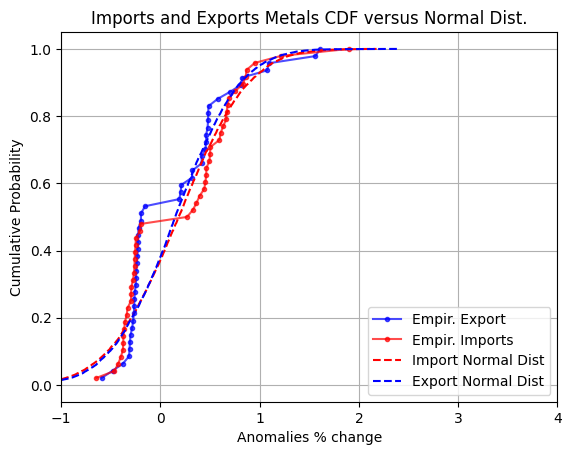

In [46]:
exp_cumulative_prob = np.arange(1, len(exp_sorted) + 1) / len(exp_sorted)
imp_cumulative_prob = np.arange(1, len(imp_sorted) + 1) / len(imp_sorted)
# Plot the CDF
plt.plot(exp_sorted, exp_cumulative_prob, marker='.', alpha=0.7, label='Empir. Export', c='blue')
plt.plot(imp_sorted, imp_cumulative_prob, marker='.', alpha=0.7, label='Empir. Imports', c= 'red')

# Plot theoretical normal CDF
normal_sorted = np.sort(np.random.normal(np.mean(imp_sorted), np.std(imp_sorted), 10000))
normal_cumulative_prob = np.arange(1, len(normal_sorted) + 1) / len(normal_sorted)
plt.plot(normal_sorted, normal_cumulative_prob, label='Import Normal Dist', c='red', ls='--')

normal_sorted = np.sort(np.random.normal(np.mean(exp_sorted), np.std(exp_sorted), 10000))
normal_cumulative_prob = np.arange(1, len(normal_sorted) + 1) / len(normal_sorted)
plt.plot(normal_sorted, normal_cumulative_prob, label='Export Normal Dist', c='blue', ls='--')


plt.title('Imports and Exports Metals CDF versus Normal Dist.')
plt.xlabel(f'Anomalies % change')
plt.legend()
plt.xlim(-1,4)
plt.ylabel('Cumulative Probability')
plt.grid()
# plt.savefig('metals_im_ex_cdf.png', dpi=600)

((array([-2.18794508, -1.81466696, -1.5940389 , -1.43152593, -1.29991017,
         -1.18761792, -1.08858668, -0.99921942, -0.91719469, -0.84091983,
         -0.76924975, -0.7013297 , -0.63650166, -0.57424545, -0.51414026,
         -0.45583845, -0.39904728, -0.34351563, -0.28902427, -0.23537844,
         -0.18240202, -0.12993297, -0.07781945, -0.02591656,  0.02591656,
          0.07781945,  0.12993297,  0.18240202,  0.23537844,  0.28902427,
          0.34351563,  0.39904728,  0.45583845,  0.51414026,  0.57424545,
          0.63650166,  0.7013297 ,  0.76924975,  0.84091983,  0.91719469,
          0.99921942,  1.08858668,  1.18761792,  1.29991017,  1.43152593,
          1.5940389 ,  1.81466696,  2.18794508]),
  array([-0.64661588, -0.46467677, -0.42748028, -0.39925126, -0.37928513,
         -0.37478206, -0.37473056, -0.36512311, -0.3584956 , -0.34084753,
         -0.33169103, -0.2970702 , -0.29576315, -0.29338093, -0.27702456,
         -0.26696099, -0.26137893, -0.26077892, -0.25582867, -

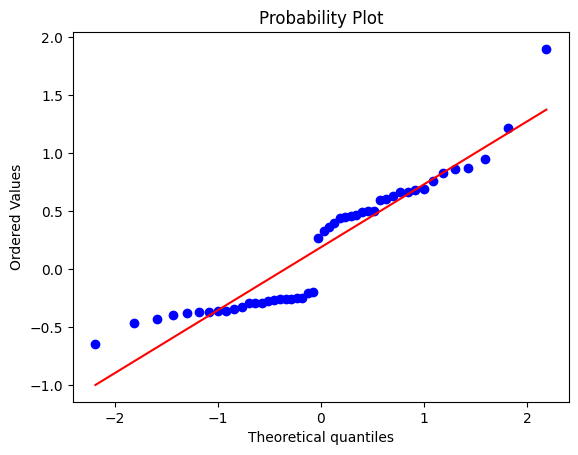

In [47]:
from scipy.stats import probplot
probplot(imp_sorted, dist='norm', plot=plt)

In [48]:
# imp = probplot(imp_sorted, dist='norm') #plot=plt
# exp = probplot(exp_sorted, dist='norm')

# fig, ax = plt.subplots(1,2, figsize=(12,6))
# ax[0].scatter(imp[0][0],imp[0][1])
# # add y=x line
# x = np.linspace(-2,2,100)
# ax[0].set_title('Imports')

# ax[1].scatter(exp[0][0],exp[0][1])
# ax[1].set_title('Exports')

# # Set major title
# fig.suptitle('P-P plot for Metals Imports and Exports Anomalies CDF vs Normal CDF')

The P-P plot shows tails are thin on negative and fat on positive versus normal distribution. Obvious given that percentages can only be -100%, but max can be any number (in theory)

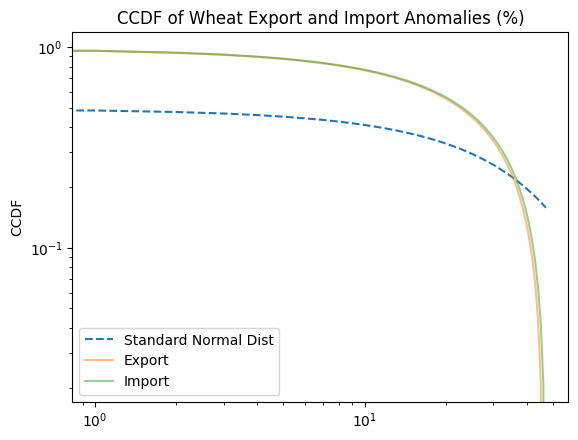

In [49]:
# Fat tails
exp_ccdf = 1 - exp_cumulative_prob
imp_ccdf = 1 - imp_cumulative_prob
normal_ccdf = scipy.stats.norm.sf(imp_cumulative_prob, 0, 1)

plt.loglog(normal_ccdf, alpha=1, label='Standard Normal Dist', linestyle='--')
plt.loglog(exp_ccdf, alpha=0.5, label='Export')
plt.loglog(imp_ccdf, alpha=0.5, label='Import')
plt.legend()
plt.title('CCDF of Wheat Export and Import Anomalies (%)')
plt.ylabel('CCDF')
plt.savefig('wheat_ccdf.png', dpi=600)

By examining the behavior of the CCDF you can determine if the distribution exhibits exponential decay. If the CCDF shows a straight line on a logarithmic scale, it suggests exponential decay. Additionally, you can perform statistical tests to confirm if the data follows an exponential distribution.

Normality tests:

In [50]:
# Kolmogorov-Smirnov Test
ks_statistic, ks_pvalue = kstest(exp_temp, 'norm')
print(f'Export KS Statistic: {ks_statistic}, P-value: {ks_pvalue}')

ks_statistic, ks_pvalue = kstest(imp_temp, 'norm')
print(f'Import KS Statistic: {ks_statistic}, P-value: {ks_pvalue}')

# Anderson-Darling Test
ad_statistic, ad_critical_values, ad_significance_levels = anderson(exp_temp, dist='norm')
print(f'Export AD Statistic: {ad_statistic}, Critical Values: {ad_critical_values}, Significance Levels: {ad_significance_levels}')

ad_statistic, ad_critical_values, ad_significance_levels = anderson(imp_temp, dist='norm')
print(f'Import AD Statistic: {ad_statistic}, Critical Values: {ad_critical_values}, Significance Levels: {ad_significance_levels}')


Export KS Statistic: 0.3229036217089105, P-value: 8.65077206174714e-06
Import KS Statistic: 0.3002481410456688, P-value: 0.0002468867833817096
Export AD Statistic: 8.393347171988552, Critical Values: [0.542 0.617 0.741 0.864 1.028], Significance Levels: [15.  10.   5.   2.5  1. ]
Import AD Statistic: 2.1737339466711276, Critical Values: [0.537 0.612 0.734 0.856 1.018], Significance Levels: [15.  10.   5.   2.5  1. ]


for low and high GDP countries, the p-valus are significant at 1% level, where for mid its 3% significance in terms of export and import causality across all nations over the time frame at a 1 and 2yr lag


Import and export anomalies vs export anomalies cnanot be compared, nor can anomalies within commodities/GDPs because they are not equal in size or countries/timeframes.

Skew in anomalies

In [51]:
# pct_change in year after upward or downward shock - should be mean reverting
# Define function to find anomalies and store the indices of the next value
def find_anomalies_next_indices(z_scores_df, pct_df, anomalies_up_list, anomalies_down_list):
    indices_up = z_scores_df > 3
    indices_down = z_scores_df < -3
    for column in z_scores_df.columns:
        for index, value in indices_up[column].items():
            if value:
                # Append index of the next value after the anomaly
                next_index = index + 1
                if next_index < pct_df.index[-1]:
                    anomalies_up_list.append(pct_df.loc[next_index, column])
        for index, value in indices_down[column].items():
            if value:
                # Append index of the next value after the anomaly
                next_index = index + 1
                if next_index < pct_df.index[-1]:
                    anomalies_down_list.append(pct_df.loc[next_index, column])


mean_rev = {'meat': {}, 'wheat': {}, 'metals': {}}
for key in gdp_split:
    exp_zdfs = [gdp_split[key]['low_gdp_exp_z'], gdp_split[key]['mid_gdp_exp_z'], gdp_split[key]['high_gdp_exp_z']]
    exp_pct_dfs = [gdp_split[key]['low_gdp_exp'], gdp_split[key]['mid_gdp_exp'], gdp_split[key]['high_gdp_exp']]
    imp_zdfs = [gdp_split[key]['low_gdp_imp_z'], gdp_split[key]['mid_gdp_imp_z'], gdp_split[key]['high_gdp_imp_z']]
    imp_pct_dfs = [gdp_split[key]['low_gdp_imp'], gdp_split[key]['mid_gdp_imp'], gdp_split[key]['high_gdp_imp']]

    exp_anomalies_low_up = []
    exp_anomalies_mid_up = []
    exp_anomalies_high_up = []
    exp_anomalies_low_down = []
    exp_anomalies_mid_down = []
    exp_anomalies_high_down = []

    imp_anomalies_low_up = []
    imp_anomalies_mid_up = []
    imp_anomalies_high_up = []
    imp_anomalies_low_down = []
    imp_anomalies_mid_down = []
    imp_anomalies_high_down = []

    # Find next value after anomalies
    exp_ups = [exp_anomalies_low_up, exp_anomalies_mid_up, exp_anomalies_high_up]
    exp_downs = [exp_anomalies_low_down, exp_anomalies_mid_down, exp_anomalies_high_down]
    imp_ups = [imp_anomalies_low_up, imp_anomalies_mid_up, imp_anomalies_high_up]
    imp_downs = [imp_anomalies_low_down, imp_anomalies_mid_down, imp_anomalies_high_down]
    for i in range(3):
        find_anomalies_next_indices(exp_zdfs[i], exp_pct_dfs[i], exp_ups[i], exp_downs[i])
        find_anomalies_next_indices(imp_zdfs[i], imp_pct_dfs[i], imp_ups[i], imp_downs[i])
    
    mean_rev[key]['exp_ups'] = exp_ups
    mean_rev[key]['exp_downs'] = exp_downs
    mean_rev[key]['imp_ups'] = imp_ups
    mean_rev[key]['imp_downs'] = imp_downs

In [52]:
# count number of positive vs negative values for each of the 4 lists- exp_ups, exp_downs, imp_ups, imp_downs
from scipy.stats import ttest_1samp
for key in mean_rev:
    # next value after anomaly: Ups means next value after positive anomaly
    exp_ups = mean_rev[key]['exp_ups']
    exp_downs = mean_rev[key]['exp_downs']
    imp_ups = mean_rev[key]['imp_ups']
    imp_downs = mean_rev[key]['imp_downs']
    
    exp_ups_pos = len([x for x in exp_ups[0] if x > 0]) + len([x for x in exp_ups[1] if x > 0]) + len([x for x in exp_ups[2] if x > 0])
    exp_ups_neg = len([x for x in exp_ups[0] if x < 0]) + len([x for x in exp_ups[1] if x < 0]) + len([x for x in exp_ups[2] if x < 0])
    
    # Perform a t-test on the post positive export anomalies data - are they significantly different from 0?
    post_pos_anomalies = np.concatenate((np.array(exp_ups[0]),np.array(exp_ups[1]),np.array(exp_ups[2])))
    t_stat, p_value = ttest_1samp(post_pos_anomalies, 0)
    print(f'{key}:\nExports:\n')
    print(f"T-test P-value positive anomalies: {p_value}")

    exp_downs_pos = len([x for x in exp_downs[0] if x > 0]) + len([x for x in exp_downs[1] if x > 0]) + len([x for x in exp_downs[2] if x > 0])
    exp_downs_neg = len([x for x in exp_downs[0] if x < 0]) + len([x for x in exp_downs[1] if x < 0]) + len([x for x in exp_downs[2] if x < 0])
    
    # Perform a t-test on the post negative export anomalies data
    post_neg_anomalies = np.concatenate((np.array(exp_downs[0]),np.array(exp_downs[1]),np.array(exp_downs[2])))
    t_stat, p_value = ttest_1samp(post_neg_anomalies, 0)
    print(f"T-test P-value negative anomalies: {p_value}")
    print(f'Up after up shock: {exp_ups_pos}, Down after up shock: {exp_ups_neg}\nUp after down shock: {exp_downs_pos}, Down after Down shock: {exp_downs_neg} \n')

    imp_ups_pos = len([x for x in imp_ups[0] if x > 0]) + len([x for x in imp_ups[1] if x > 0]) + len([x for x in imp_ups[2] if x > 0])
    imp_ups_neg = len([x for x in imp_ups[0] if x < 0]) + len([x for x in imp_ups[1] if x < 0]) + len([x for x in imp_ups[2] if x < 0])

    post_pos_anomalies = np.concatenate((np.array(imp_ups[0]),np.array(imp_ups[1]),np.array(imp_ups[2])))
    t_stat, p_value = ttest_1samp(post_pos_anomalies, 0)
    print(f'Imports:\n')
    print(f"T-test P-value positive anomalies: {p_value}")

    imp_downs_pos = len([x for x in imp_downs[0] if x > 0]) + len([x for x in imp_downs[1] if x > 0]) + len([x for x in imp_downs[2] if x > 0])
    imp_downs_neg = len([x for x in imp_downs[0] if x < 0]) + len([x for x in imp_downs[1] if x < 0]) + len([x for x in imp_downs[2] if x < 0])
    
    post_neg_anomalies = np.concatenate((np.array(imp_downs[0]),np.array(imp_downs[1]),np.array(imp_downs[2])))
    t_stat, p_value = ttest_1samp(post_neg_anomalies, 0)
    print(f"T-test P-value negative anomalies: {p_value}")
    
    print(f"\nUp after up shock: {imp_ups_pos}, Down after up shock: {imp_ups_neg}\nUp after down shock: {imp_downs_pos}, Down after Down shock: {imp_downs_neg} \n")
    print('\n\n')

meat:
Exports:

T-test P-value positive anomalies: 0.5123359489766394
T-test P-value negative anomalies: 0.36157247198348785
Up after up shock: 33, Down after up shock: 38
Up after down shock: 3, Down after Down shock: 1 

Imports:

T-test P-value positive anomalies: 0.24439007034141333
T-test P-value negative anomalies: 0.3797225577472274

Up after up shock: 32, Down after up shock: 20
Up after down shock: 7, Down after Down shock: 2 




wheat:
Exports:

T-test P-value positive anomalies: 0.7331009051352366
T-test P-value negative anomalies: 0.4524435660198586
Up after up shock: 33, Down after up shock: 38
Up after down shock: 1, Down after Down shock: 4 

Imports:

T-test P-value positive anomalies: 0.5843288603406755
T-test P-value negative anomalies: 0.36129447037899554

Up after up shock: 29, Down after up shock: 36
Up after down shock: 1, Down after Down shock: 2 




metals:
Exports:

T-test P-value positive anomalies: 0.3401961195383373
T-test P-value negative anomalies: 5.391

Down shocks usually mean revert, up shocks may be longer term trends

### Causality
Testing causality between imports and exports within each commodity, which may help assess whether the mean reversion/trend after anomalies is significant

In [53]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causality_test(data, max_lag):
    results = grangercausalitytests(data, max_lag, verbose=False)
    for lag in range(1, max_lag + 1):
        p_value = results[lag][0]['ssr_ftest'][1]
        print(f"Lag {lag}: p-value = {p_value}")

Within commodities exports versus imports:

In [54]:
for key in ann_dict:
    print(f'{key}:')
    exp_temp = ann_dict[key]['export_df'].pct_change().loc[2006:2023,:] # dropping predictions
    imp_temp = ann_dict[key]['import_df'].pct_change().loc[2006:2023,:]
    common_countries = exp_temp.columns.intersection(imp_temp.columns)
    exp_temp = exp_temp[common_countries]
    imp_temp = imp_temp[common_countries]
    granger_causality_test(pd.DataFrame([exp_temp.stack(),imp_temp.stack()]).T, 4) # second column does not granger cause first column
    print('\n')
    granger_causality_test(pd.DataFrame([imp_temp.stack(),exp_temp.stack()]).T, 4)
    print('\n')

meat:
Lag 1: p-value = 0.5516940548441732
Lag 2: p-value = 0.8357049270089723
Lag 3: p-value = 0.8769677905562454
Lag 4: p-value = 0.8542644571813627


Lag 1: p-value = 0.40116784651443615
Lag 2: p-value = 0.6864085042360278
Lag 3: p-value = 0.8613854674680995
Lag 4: p-value = 0.9242548176772939


wheat:
Lag 1: p-value = 0.9814461384992426
Lag 2: p-value = 0.9664692509318504
Lag 3: p-value = 0.9858836428588955
Lag 4: p-value = 0.9938349573937693


Lag 1: p-value = 0.9052741877084814
Lag 2: p-value = 0.9928109453569814
Lag 3: p-value = 0.9982692469217359
Lag 4: p-value = 0.9996189654839357


metals:
Lag 1: p-value = 0.1572234378349561
Lag 2: p-value = 0.167390066772747
Lag 3: p-value = 0.002830171727405542
Lag 4: p-value = 0.006209424205671293


Lag 1: p-value = 0.5657927091864889
Lag 2: p-value = 0.8821099690225214
Lag 3: p-value = 0.5817076566528625
Lag 4: p-value = 0.5731139097000104




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since fu

Across commodities imports vs imports, exports vs exports:

In [55]:
# X causes Y, so need both sets of combos = 3! combos
combinations = [('meat', 'wheat'), ('meat', 'metals'), ('wheat', 'metals'), ('wheat', 'meat'), ('metals', 'meat'), ('metals', 'wheat')]

for combo in combinations:
    print(f'{combo[0]} vs {combo[1]}:')
    print('Exports:\n')
    exp_one = ann_dict[combo[0]]['export_df'].pct_change().loc[2006:2023,:]
    exp_two = ann_dict[combo[1]]['export_df'].pct_change().loc[2006:2023,:]
    common_countries = exp_one.columns.intersection(exp_two.columns)
    exp_one = exp_one[common_countries]
    exp_two = exp_two[common_countries]
    granger_causality_test(pd.DataFrame([exp_one.stack(),exp_two.stack()]).T.fillna(0), 4)

    print('\nImports:\n')
    imp_one = ann_dict[combo[0]]['import_df'].pct_change().loc[2006:2023,:]
    imp_two = ann_dict[combo[1]]['import_df'].pct_change().loc[2006:2023,:]
    common_countries = imp_one.columns.intersection(imp_two.columns)
    imp_one = imp_one[common_countries].fillna(0)
    imp_two = imp_two[common_countries].fillna(0)
    granger_causality_test(pd.DataFrame([imp_one.stack(),imp_two.stack()]).T, 4)
    print('\n\n')

meat vs wheat:
Exports:



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag 1: p-value = 0.979235877811638
Lag 2: p-value = 0.9993035423808633
Lag 3: p-value = 0.9999735477578462
Lag 4: p-value = 0.9999989221789779

Imports:



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since fu

Lag 1: p-value = 0.8612134469850343
Lag 2: p-value = 0.5698015170366444
Lag 3: p-value = 0.38750335051838153
Lag 4: p-value = 0.4556361214160606



meat vs metals:
Exports:

Lag 1: p-value = 0.9387429042797545
Lag 2: p-value = 0.9863769652146623
Lag 3: p-value = 0.9926253524956697
Lag 4: p-value = 0.9951093420319724

Imports:

Lag 1: p-value = 0.043745390057238785
Lag 2: p-value = 0.0326362636251685
Lag 3: p-value = 0.027942174321757735
Lag 4: p-value = 0.00012609326432907786



wheat vs metals:
Exports:

Lag 1: p-value = 0.8864130950820832
Lag 2: p-value = 0.9898118099001961
Lag 3: p-value = 0.9982956672710483
Lag 4: p-value = 0.9339281586730338

Imports:

Lag 1: p-value = 0.14651600241716145
Lag 2: p-value = 0.29643622337482123
Lag 3: p-value = 0.47462581384205993
Lag 4: p-value = 0.5368208816200433



wheat vs meat:
Exports:

Lag 1: p-value = 0.9785476819750911
Lag 2: p-value = 0.9992654495437246
Lag 3: p-value = 0.9999724130937909
Lag 4: p-value = 0.9999988489387638

Imports:

Lag 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since fu

## Correlation across and within Commodities for anomalies

Have to take subset to reduce 'dimensionality' of the problem and reduce noise with small countries which may be data issues

### Correlation across commodities

- Get the subset countries, count the number per year 

In [56]:
# using dataframes rather than arrays for time series component
gdp_anomalies = {'meat': {}, 'wheat': {}, 'metals': {}}

for key in gdp_split:
    exp_zdfs = [gdp_split[key]['low_gdp_exp_z'], gdp_split[key]['mid_gdp_exp_z'], gdp_split[key]['high_gdp_exp_z']]
    exp_pct_dfs = [gdp_split[key]['low_gdp_exp'], gdp_split[key]['mid_gdp_exp'], gdp_split[key]['high_gdp_exp']]
    imp_zdfs = [gdp_split[key]['low_gdp_imp_z'], gdp_split[key]['mid_gdp_imp_z'], gdp_split[key]['high_gdp_imp_z']]
    imp_pct_dfs = [gdp_split[key]['low_gdp_imp'], gdp_split[key]['mid_gdp_imp'], gdp_split[key]['high_gdp_imp']]

    exp_anomalies = []
    imp_anomalies = []

    for i in range(3):
        exp_indices = (exp_zdfs[i] > 3) | (exp_zdfs[i] < -3)
        imp_indices = (imp_zdfs[i] > 3) | (imp_zdfs[i] < -3)

        temp_exp = exp_pct_dfs[i][exp_indices].stack().dropna()
        temp_imp = imp_pct_dfs[i][imp_indices].stack().dropna()

        exp_anomalies.append(temp_exp)
        imp_anomalies.append(temp_imp)

    gdp_anomalies[key]['exp_anomalies'] = pd.concat(exp_anomalies, ignore_index=False)
    gdp_anomalies[key]['imp_anomalies'] = pd.concat(imp_anomalies, ignore_index=False)

gdp_anomalies['wheat']['exp_anomalies'] = gdp_anomalies['wheat']['exp_anomalies'].drop((2015, 'Angola'))
gdp_anomalies['meat']['exp_anomalies'] = gdp_anomalies['meat']['exp_anomalies'].drop((2018, 'Venezuela'))

gdp_anomalies['wheat']['exp_anomalies'] = pd.DataFrame(gdp_anomalies['wheat']['exp_anomalies'], columns = ['Wheat_Anomaly'])
gdp_anomalies['meat']['exp_anomalies'] = pd.DataFrame(gdp_anomalies['meat']['exp_anomalies'], columns = ['Meat_Anomaly'])
gdp_anomalies['metals']['exp_anomalies'] = pd.DataFrame(gdp_anomalies['metals']['exp_anomalies'], columns = ['Metals_Anomaly'])
# gdp_anomalies['metals']['exp_anomalies'].columns = ['Metals_Anomaly']

gdp_anomalies['wheat']['imp_anomalies'] = pd.DataFrame(gdp_anomalies['wheat']['imp_anomalies'], columns = ['Wheat_Anomaly'])
gdp_anomalies['meat']['imp_anomalies'] = pd.DataFrame(gdp_anomalies['meat']['imp_anomalies'], columns = ['Meat_Anomaly'])
gdp_anomalies['metals']['imp_anomalies'] = pd.DataFrame(gdp_anomalies['metals']['imp_anomalies'], columns = ['Metals_Anomaly'])

exp_anomalies = pd.concat([gdp_anomalies['wheat']['exp_anomalies'], gdp_anomalies['meat']['exp_anomalies'], 
                      gdp_anomalies['metals']['exp_anomalies']], axis=0)
exp_anomalies = exp_anomalies.sort_index()
exp_anomalies = exp_anomalies.groupby(level=[0,1]).first()

imp_anomalies = pd.concat([gdp_anomalies['wheat']['imp_anomalies'], gdp_anomalies['meat']['imp_anomalies'], 
                      gdp_anomalies['metals']['imp_anomalies']], axis=0)
imp_anomalies = imp_anomalies.sort_index()
imp_anomalies = imp_anomalies.groupby(level=[0,1]).first()
imp_anomalies.head(3)

Wheat_Anomaly  Meat_Anomaly  Metals_Anomaly
2006 Brazil           0.284317           NaN             NaN
     Chile            1.485385           NaN             NaN
     Costa Rica            NaN           NaN        0.665688

In [57]:
# Count non nan values across the columns for each year i.e. there is an anomaly in a country for 2 commodities in 1 year
exp_anomalies_count = exp_anomalies.count(axis=1)
exp_anom_corr = exp_anomalies_count[exp_anomalies_count>1]
imp_anomalies_count = imp_anomalies.count(axis=1)
imp_anom_corr = imp_anomalies_count[imp_anomalies_count>1]
print(f'Number of countries with more than 1 commodity import anomaly in a year: {imp_anom_corr.shape[0]} out of {imp_anomalies_count.shape[0]}\n')
print(f'Number of countries with more than 1 commodity export anomaly in a year: {exp_anom_corr.shape[0]} out of {exp_anomalies_count.shape[0]}')

Number of countries with more than 1 commodity import anomaly in a year: 12 out of 164

Number of countries with more than 1 commodity export anomaly in a year: 9 out of 197


In [58]:
# exp_anomalies = pd.DataFrame(np.where(exp_anomalies != 0, 1, 0), columns=exp_anomalies.columns)
# imp_anomalies = pd.DataFrame(np.where(imp_anomalies != 0, 1, 0), columns=imp_anomalies.columns)

In [59]:
# If fillna then all insignificant correlations apart from meat and wheat for both exports and imports
# exp_anomalies = exp_anomalies.fillna(0)
# imp_anomalies = imp_anomalies.fillna(0)

# Test correlation between anomalies and within anomaly
a = spearmanr(exp_anomalies['Meat_Anomaly'], exp_anomalies['Wheat_Anomaly'])
b = spearmanr(exp_anomalies['Meat_Anomaly'], exp_anomalies['Metals_Anomaly'])
c = spearmanr(exp_anomalies['Wheat_Anomaly'], exp_anomalies['Metals_Anomaly'])

d = spearmanr(imp_anomalies['Meat_Anomaly'], imp_anomalies['Wheat_Anomaly'])
e = spearmanr(imp_anomalies['Meat_Anomaly'], imp_anomalies['Metals_Anomaly'])
f = spearmanr(imp_anomalies['Wheat_Anomaly'], imp_anomalies['Metals_Anomaly'])
a,b,c,d,e,f

(SignificanceResult(statistic=nan, pvalue=nan),
 SignificanceResult(statistic=nan, pvalue=nan),
 SignificanceResult(statistic=nan, pvalue=nan),
 SignificanceResult(statistic=nan, pvalue=nan),
 SignificanceResult(statistic=nan, pvalue=nan),
 SignificanceResult(statistic=nan, pvalue=nan))

Not many across commodities in the same country and year. No correlation/relation between the countries with anomalies in the same year either, as they arent even in the same continent for almost all occurences. e.g. 2021 columbia and new zealand both had 2/3 commodities wtih large anomalies. Another thing to note though is that almost all were in 2007-10 period for >1 anomaly across commodities, again suggesting the impact of GFC on global trade, so they are linked to global events. This is informative for our network analysis in the group project. Also no consistency in the countries which experience import and export anomalies across commodities - no country was the same in both groups.

### Within Commodities
- Split into the different subsets within each commodity and see if more anomalies in 1 over the other and if anomalies across the subsets occur in same year etc

In [60]:
commodity = 'wheat'

In [61]:
if commodity == 'metals':
    temp_countries = selected_countries.copy()
    temp_countries.remove('Yemen')
    temp_countries.remove('Nepal')
    temp_countries.remove('Mozambique')
    in_comm_corr = ann_metals_df.loc[(ann_metals_df['Export Country/Territory'].isin(temp_countries))]
    in_comm_corr = in_comm_corr.drop(['Start Date', 'End Date', 'Concept'], axis=1)
    splits = in_comm_corr.groupby('Commodity')
    splits_list = list(splits)
    comm_splits = {splits_list[i][0]: splits_list[i][1].loc[:2023,:] for i in range(len(splits_list))}

elif commodity == 'meat':
    temp_countries = selected_countries
    in_comm_corr = ann_meat_df.loc[(ann_meat_df['Export Country/Territory'].isin(temp_countries))]
    in_comm_corr = in_comm_corr.drop(['Start Date', 'End Date', 'Concept'], axis=1)
    splits = in_comm_corr.groupby('Commodity')
    splits_list = list(splits)
    comm_splits = {splits_list[i][0]: splits_list[i][1].loc[:2023,:] for i in range(len(splits_list))}

else:
    temp_countries = selected_countries
    in_comm_corr = ann_wheat_df.loc[(ann_wheat_df['Export Country/Territory'].isin(temp_countries))]
    in_comm_corr = in_comm_corr.drop(['Start Date', 'End Date', 'Concept'], axis=1)
    splits = in_comm_corr.groupby('Commodity')
    splits_list = list(splits)
    comm_splits = {splits_list[i][0]: splits_list[i][1].loc[:2023,:] for i in range(len(splits_list))}

comm_splits.keys()

dict_keys(['Wheat', 'Wheat and cereal flour, products and malt'])

In [62]:
def incomm_process_data(df, commodity, subset_countries=None):
    
    if commodity == 'metals':
        years = list(range(2005, 2035))
    else:
        years = list(range(2005, 2041))

    df.columns = ['Import Country/Territory', 
                  'Export Country/Territory', 'Commodity'] + years

    export_df, import_df = pd.DataFrame(), pd.DataFrame()
    countries = df['Export Country/Territory'].unique()
    for i, country in enumerate(countries):
        ex_frame = df.loc[(df['Export Country/Territory'] == country)]
        im_frame = df.loc[(df['Import Country/Territory'] == country)]
        ex_values = []
        im_values = []
        for j in years:
            ex_values.append(ex_frame[j].sum(skipna=True))
            im_values.append(im_frame[j].sum(skipna=True))
            
        export_df[country] = ex_values
        import_df[country] = im_values

    import_df.index = years
    export_df.index = years
    
    if subset_countries:
        import_df = import_df.loc[:, subset_countries]
        export_df = export_df.loc[:, subset_countries]
    
    export_zs = zscore(export_df.pct_change().iloc[1:,:], axis=0)
    export_zs = export_zs.dropna(axis=0, how='all')
    import_zs = zscore(import_df.pct_change().iloc[1:,:], axis=0)
    import_zs = import_zs.dropna(axis=0, how='all')

    return export_df, import_df, export_zs, import_zs

In [63]:
exports, imports = {key: {} for key in comm_splits}, {key: {} for key in comm_splits}
for key in comm_splits:
    export_df, import_df, export_zs, import_zs = incomm_process_data(comm_splits[key], commodity) #subset_countries=temp_countries 
    exports[key]['export_df'] = export_df.pct_change().iloc[1:,:]
    exports[key]['export_zs'] = export_zs
    imports[key]['import_df'] = import_df.pct_change().iloc[1:,:]
    imports[key]['import_zs'] = import_zs

In [64]:
exp_anomalies, imp_anomalies = {key:{} for key in exports}, {key:{} for key in imports}
for key in exports:

    exp_indices = (exports[key]['export_zs'] > 3) | (exports[key]['export_zs'] < -3)
    imp_indices = (imports[key]['import_zs'] > 3) | (imports[key]['import_zs'] < -3)
    
    exp_temp = exports[key]['export_df'][exp_indices].dropna(how='all', axis=1).dropna(how='all', axis=0)  #.values.flatten())
    imp_temp = imports[key]['import_df'][imp_indices].dropna(how='all', axis=1).dropna(how='all', axis=0)

    multi_index_exp = exp_temp.stack()
    multi_index_imp = imp_temp.stack()
    multi_index_exp.name = 'Anomaly'
    multi_index_imp.name = 'Anomaly'
    multi_index_exp = multi_index_exp.reset_index()
    multi_index_imp = multi_index_imp.reset_index()

    multi_index_exp.columns = ['Year', 'Country', f'{key}_Anomaly']
    multi_index_imp.columns = ['Year', 'Country', f'{key}_Anomaly']

    multi_index_exp.set_index(['Year', 'Country'], inplace=True)
    multi_index_imp.set_index(['Year', 'Country'], inplace=True)

    imp_anomalies[key] = multi_index_imp
    exp_anomalies[key] = multi_index_exp

In [65]:
# concatenate the exp and imp anomlaies dataframes
exp_anomalies = pd.concat([exp_anomalies[key] for key in exp_anomalies], axis=0)
exp_anomalies.sort_index(inplace=True)
exp_anomalies = exp_anomalies.groupby(level=[0,1]).first()
imp_anomalies = pd.concat([imp_anomalies[key] for key in imp_anomalies], axis=0)
imp_anomalies.sort_index(inplace=True)
imp_anomalies = imp_anomalies.groupby(level=[0,1]).first()
exp_anomalies.head(3)

Wheat_Anomaly  Wheat and cereal flour, products and malt_Anomaly
Year Country                                                                  
2006 Bolivia            NaN                                            1.98635
     Brazil        4.717408                                                NaN
     Spain         1.330251                                                NaN

In [66]:
# Count non nan values across the columns for each year i.e. there is an anomaly in a country for 2 commodities in 1 year
exp_anomalies_count = exp_anomalies.count(axis=1)
exp_anom_corr = exp_anomalies_count[exp_anomalies_count>1]
imp_anomalies_count = imp_anomalies.count(axis=1)
imp_anom_corr = imp_anomalies_count[imp_anomalies_count>1]
print(f'Number of countries with more than 1 commodity subgroup import anomaly in a year: {imp_anom_corr.shape[0]} out of {imp_anomalies_count.shape[0]}\n')
print(f'Number of countries with more than 1 commodity subgroup export anomaly in a year: {exp_anom_corr.shape[0]} out of {exp_anomalies_count.shape[0]}')

Number of countries with more than 1 commodity subgroup import anomaly in a year: 1 out of 45

Number of countries with more than 1 commodity subgroup export anomaly in a year: 1 out of 50


In [67]:
# Get unique combinations of commodity subgroups
incomm_combinations = list(itertools.combinations(exp_anomalies.columns, 2))

# Test spearman correlation within commodity subgroups
for combo in incomm_combinations:
    print(combo)
    print(spearmanr(exp_anomalies[combo[0]].fillna(0), exp_anomalies[combo[1]].fillna(0)))
    print('\n')

# metals have no significant correlations even with fill na = 0
# wheat has significant but only 2 groups at 1%
# meat only 1 - ('Beef, frozen_Anomaly', 'Meat, prepared or preserved_Anomaly') significant at 1%
# All nan if not fillna(0)

('Wheat_Anomaly', 'Wheat and cereal flour, products and malt_Anomaly')
SignificanceResult(statistic=-0.7386368562819552, pvalue=9.173549186025514e-10)


